# Unsupervised Cluster Analysis and Performance Evaluation: Comparative Analysis of Partitional (K-Means) and Density-Based (HDBSCAN) Clustering on UMAP-Optimized SBERT Features.

## 1. ESSENTIAL LIBRARIES, SETUP, AND DATA PREPARATION

### 1.1 Installation and Imports

In [1]:
# Install essential libraries
!pip install protobuf==3.20.3 --no-dependencies --force-reinstall
!pip install sentence-transformers
!pip install --upgrade umap-learn hdbscan

# Import all required libraries
import os
import re
import zipfile 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time
import seaborn as sns

# Clustering and ML Libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan

# Device Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Fix tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2026-01-10 07:21:53.776961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768029714.087246      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768029714.174220      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


### 1.2 Data Loading, Cleaning, and Preprocessing

In [2]:
# Define paths
zip_file_path = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
output_dir = './jigsaw_data_extracted'
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

# Data Extraction (Extract TRAIN.ZIP)
os.makedirs(output_dir, exist_ok=True)
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    # after extraction, the file name is train.csv
    train_df = pd.read_csv(os.path.join(output_dir, 'train.csv'))
    print(f"[INFO] Dataset loaded. Initial Shape: {train_df.shape}")

except Exception as e:
    print(f"[ERROR] Data loading failed: {e}. Please check the file path.")
    
# Cleaning Functions
emoji_pattern = re.compile(
    "[" 
    u"\\U0001F600-\\U0001F64F" # Emoticons
    u"\\U0001F300-\\U0001F5FF" # Symbols & Pictographs
    u"\\U0001F680-\\U0001F6FF" # Transport & Map Symbols
    u"\\U0001F1E0-\\U0001F1FF" # Regional Indicators (Flags)
    u"\\U00002700-\\U000027BF" # Dingbats/Miscellaneous Symbols
    u"\\U0001F900-\\U0001F9FF" # Supplemental Symbols and Pictographs
    "]+", flags=re.UNICODE)

def bert_minimal_clean(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    # Remove URLs (using the broader pattern)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove mentions (added for robustness, though not in your last snippet)
    text = re.sub(r'@\w+', ' ', text) 
    # Remove HTML Tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove Emojis
    text = emoji_pattern.sub(" ", text)
    # Normalize and strip whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Duplicate Handling Function
def drop_dup_keep_if_labels_identical(df, text_col, label_cols):
    if df.empty:
        return df
    groups = df.groupby(text_col)
    keep_idx = []
    for txt, idxs in groups.groups.items():
        subset = df.loc[idxs]
        # Keep only one if all labels across the duplicates are identical (nunique max is 1)
        if (subset[label_cols].nunique().max() == 1):
            keep_idx.append(subset.index[0])
        else:
            # Keep all if labels show variation (different labels for same text)
            keep_idx.extend(subset.index.tolist())
    return df.loc[sorted(keep_idx)].reset_index(drop=True)

# Apply Cleaning and Filtering
train_df_clean = train_df.copy()
train_df_clean['comment_text_bert'] = train_df_clean['comment_text'].apply(bert_minimal_clean)

# Remove empty comments
train_df_clean = train_df_clean[train_df_clean['comment_text_bert'].str.strip() != ""]

# Remove duplicates with identical labels
train_df_clean = drop_dup_keep_if_labels_identical(train_df_clean, 'comment_text_bert', label_cols)

print(f"[INFO] Final Clean Train Shape: {train_df_clean.shape}")

[INFO] Dataset loaded. Initial Shape: (159571, 8)
[INFO] Final Clean Train Shape: (159330, 9)


## 2. TEXT EMBEDDING AND DIMENSIONALITY REDUCTION

### 2.1 Sentence-Transformer Embedding (SBERT)

In [3]:
# Prepare all texts for embedding
all_texts = train_df_clean['comment_text_bert'].tolist()

# Load SBERT Model
model_sbert = SentenceTransformer('all-MiniLM-L6-v2', device=device) 
print(f"[INFO] SBERT Model loaded on {device}.")

# Generate Embeddings
t_embed_0 = time.time()
embeddings = model_sbert.encode(all_texts, 
                                 show_progress_bar=True, 
                                 convert_to_tensor=False)
t_embed_1 = time.time()

print(f"[INFO] Embeddings generated in {t_embed_1 - t_embed_0:.2f} seconds.")
print(f"[INFO] Embeddings shape: {embeddings.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[INFO] SBERT Model loaded on cuda.


Batches:   0%|          | 0/4980 [00:00<?, ?it/s]

[INFO] Embeddings generated in 133.28 seconds.
[INFO] Embeddings shape: (159330, 384)


### 2.2 UMAP 5D Dimensionality Reduction

In [4]:
!pip install umap-learn==0.5.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82810 sha256=4c297a51520d28b5b9032a99da75aedbcb38270edce55637eb05860a82adac62
  Stored in directory: /root/.cache/pip/wheels/02/15/cd/b456fcce97d704f38b583aecf7fa174860b6ff0b499f51f95a
Successfully built umap-learn
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.9.post2
    Uninstalling umap-learn-0.5.9.post2:
      Successfully uninstalled umap-learn-0.5.9.post2


In [5]:
# Apply UMAP (Reducing to 5D)
t_umap_0 = time.time()
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42)
X_umap_5d = reducer.fit_transform(embeddings) 
t_umap_1 = time.time()

print(f"[INFO] UMAP Reduction complete in {t_umap_1 - t_umap_0:.2f} seconds.")
print(f"[INFO] X_umap_5d shape: {X_umap_5d.shape}")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  elif (


[INFO] UMAP Reduction complete in 247.71 seconds.
[INFO] X_umap_5d shape: (159330, 5)


## 3. K-Means Clustering

### 3.1 Optimal K-Value Determination (Elbow Method)

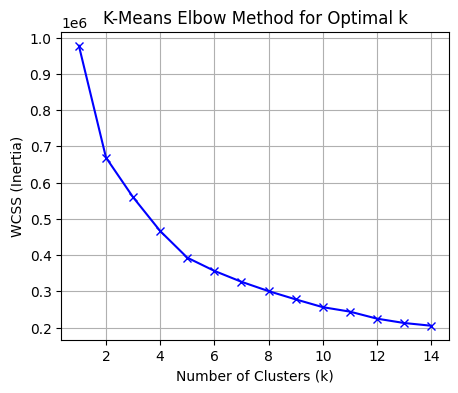

In [6]:
wcss = []
k_values = range(1, 15)
for k in k_values:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_model.fit(X_umap_5d)
    wcss.append(kmeans_model.inertia_)

plt.figure(figsize=(5, 4))
plt.plot(k_values, wcss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('K-Means Elbow Method for Optimal k')
plt.grid(True)
plt.show()

### 3.2 K-Means Model Fitting, Performance Scoring & External Validation

In [7]:
# Create is_toxic column for external metrics
train_df_clean['is_toxic'] = train_df_clean[label_cols].sum(axis=1) > 0

optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_umap_5d)
train_df_clean['KMeans_Cluster'] = kmeans_labels 

# Internal Metrics Calculation
kmeans_silhouette = silhouette_score(X_umap_5d, kmeans_labels)
kmeans_ch_score = calinski_harabasz_score(X_umap_5d, kmeans_labels)
kmeans_db_score = davies_bouldin_score(X_umap_5d, kmeans_labels)

print(f"\n--- K-Means Evaluation Metrics (k={optimal_k}) ---")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Calinski-Harabasz Index (Higher is Better): {kmeans_ch_score:.2f}")
print(f"Davies-Bouldin Index (Lower is Better): {kmeans_db_score:.2f}")

# External Validation Metrics
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import pandas as pd

true_labels = train_df_clean['is_toxic'].astype(int)
kmeans_labels = train_df_clean['KMeans_Cluster']

# NMI (Normalized Mutual Information)
kmeans_nmi = normalized_mutual_info_score(true_labels, kmeans_labels)

# ARI (Adjusted Rand Index)
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

# Purity function
def cluster_purity(labels, clusters):
    df = pd.DataFrame({'label': labels, 'cluster': clusters})
    return df.groupby('cluster')['label'].agg(lambda x: x.value_counts().max()/len(x)).mean()

kmeans_purity = cluster_purity(true_labels, kmeans_labels)

print("\n--- External Validation Metrics (KMeans) ---")
print(f"NMI Score: {kmeans_nmi:.4f}")
print(f"ARI Score: {kmeans_ari:.4f}")
print(f"Purity: {kmeans_purity:.4f}")


--- K-Means Evaluation Metrics (k=5) ---
Silhouette Score: 0.2779
Calinski-Harabasz Index (Higher is Better): 59334.00
Davies-Bouldin Index (Lower is Better): 1.25

--- External Validation Metrics (KMeans) ---
NMI Score: 0.0275
ARI Score: 0.0097
Purity: 0.8941


### 3.3 K-Means Cluster Profiling & Toxicity Breakdown

In [8]:
# K-Means Cluster Sizes
kmeans_cluster_sizes = train_df_clean['KMeans_Cluster'].value_counts().sort_index()

print("--- K-Means Cluster Sizes (k=5) ---")
print(kmeans_cluster_sizes.to_markdown())
print("-----------------------------------")

# Calculate Label Percentages per Cluster
cluster_analysis_kmeans = train_df_clean.groupby('KMeans_Cluster')[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
cluster_analysis_kmeans['Total_Samples'] = kmeans_cluster_sizes

# Calculate the percentage for each flag
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    cluster_analysis_kmeans[f'{col}_Percent'] = (cluster_analysis_kmeans[col] / cluster_analysis_kmeans['Total_Samples']) * 100

# Improved display for percentages
styled_output = cluster_analysis_kmeans.filter(like='Percent') \
                                       .sort_values(by='toxic_Percent', ascending=False) \
                                       .round(2)

print("\nK-Means Cluster Label Percentages (Highest Toxic First)")
print(styled_output.to_markdown())

# Additional: Cluster-wise toxic summary
print("\n--- Cluster-wise Toxic Summary ---")
cluster_toxic_summary = train_df_clean.groupby('KMeans_Cluster')['is_toxic'].agg(['count', 'sum', 'mean']).round(4)
cluster_toxic_summary.columns = ['Total_Comments', 'Toxic_Count', 'Toxic_Ratio']
cluster_toxic_summary = cluster_toxic_summary.sort_values('Toxic_Ratio', ascending=False)
print(cluster_toxic_summary.to_markdown())

--- K-Means Cluster Sizes (k=5) ---
|   KMeans_Cluster |   count |
|-----------------:|--------:|
|                0 |   30601 |
|                1 |   30853 |
|                2 |   37665 |
|                3 |   28525 |
|                4 |   31686 |
-----------------------------------

K-Means Cluster Label Percentages (Highest Toxic First)
|   KMeans_Cluster |   toxic_Percent |   severe_toxic_Percent |   obscene_Percent |   threat_Percent |   insult_Percent |   identity_hate_Percent |
|-----------------:|----------------:|-----------------------:|------------------:|-----------------:|-----------------:|------------------------:|
|                3 |           22.1  |                   3.59 |             14.23 |             0.99 |            13.03 |                    2.4  |
|                4 |           13.68 |                   1.04 |              7.07 |             0.33 |             6.65 |                    0.56 |
|                1 |            7.04 |                   0.44 

## 4. HDBSCAN Clustering

### 4.1 HDBSCAN Density Clustering & Validation

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10, metric='euclidean', prediction_data=False) 
hdbscan_labels = clusterer.fit_predict(X_umap_5d) 
train_df_clean['HDBSCAN_Cluster'] = hdbscan_labels 

# Multi-Metric Calculation (Excluding Noise/Outliers)
clustered_samples_indices = hdbscan_labels != -1
X_clustered = X_umap_5d[clustered_samples_indices]
hdbscan_labels_clustered = hdbscan_labels[clustered_samples_indices]

# Internal Metrics Calculation
hdbscan_silhouette = silhouette_score(X_clustered, hdbscan_labels_clustered) 
hdbscan_ch_score = calinski_harabasz_score(X_clustered, hdbscan_labels_clustered)
hdbscan_db_score = davies_bouldin_score(X_clustered, hdbscan_labels_clustered)

# Save total clusters found dynamically
hdbscan_total_clusters = len(np.unique(hdbscan_labels))

print(f"\n--- HDBSCAN Evaluation Metrics (Noise Excluded) ---")
print(f"Silhouette Score (Dynamic): {hdbscan_silhouette:.4f}")
print(f"Calinski-Harabasz Index (Higher is Better): {hdbscan_ch_score:.2f}")
print(f"Davies-Bouldin Index (Lower is Better): {hdbscan_db_score:.2f}")
print(f"Total Clusters Found (including noise): {hdbscan_total_clusters}")

# External Validation Metrics for HDBSCAN
true_labels = train_df_clean['is_toxic'].astype(int)
hdbscan_labels = train_df_clean['HDBSCAN_Cluster'].values

# Exclude noise
mask = hdbscan_labels != -1
true_labels_masked = true_labels[mask]
hdbscan_labels_masked = hdbscan_labels[mask]

# NMI
hdbscan_nmi = normalized_mutual_info_score(true_labels_masked, hdbscan_labels_masked)

# ARI
hdbscan_ari = adjusted_rand_score(true_labels_masked, hdbscan_labels_masked)

# Purity
hdbscan_purity = cluster_purity(true_labels_masked, hdbscan_labels_masked)

print("\n--- External Validation Metrics (HDBSCAN) ---")
print(f"NMI Score: {hdbscan_nmi:.4f}")
print(f"ARI Score: {hdbscan_ari:.4f}")
print(f"Purity: {hdbscan_purity:.4f}")


--- HDBSCAN Evaluation Metrics (Noise Excluded) ---
Silhouette Score (Dynamic): 0.5177
Calinski-Harabasz Index (Higher is Better): 26977.17
Davies-Bouldin Index (Lower is Better): 0.63
Total Clusters Found (including noise): 175

--- External Validation Metrics (HDBSCAN) ---
NMI Score: 0.0376
ARI Score: 0.0010
Purity: 0.9415


### 4.2 HDBSCAN Noise Quantification & Cluster Profiling

In [10]:
# Calculate HDBSCAN Cluster Sizes (includes the -1 noise cluster)
hdbscan_cluster_sizes = train_df_clean['HDBSCAN_Cluster'].value_counts().sort_index()

print("--- HDBSCAN Cluster Sizes (Total Clusters Found) ---")
print(f"Total Clusters (including noise): {hdbscan_total_clusters}") 
print("-------------------------------------------------------")

# Calculate Label Percentages per Cluster
cluster_analysis_hdbscan = train_df_clean.groupby('HDBSCAN_Cluster')[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
cluster_analysis_hdbscan['Total_Samples'] = hdbscan_cluster_sizes

# Calculate the percentage for each flag
for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    cluster_analysis_hdbscan[f'{col}_Percent'] = (cluster_analysis_hdbscan[col] / cluster_analysis_hdbscan['Total_Samples']) * 100

# Define report columns
report_columns = ['Total_Samples'] + [col for col in cluster_analysis_hdbscan.columns if col.endswith('_Percent')]

# Filter, Sort (by purity), and Round the full analysis
styled_output_hdbscan = cluster_analysis_hdbscan[report_columns] \
                                                .sort_values(by='toxic_Percent', ascending=False) \
                                                .round(2)

# Extract Top 15 toxic clusters
top_toxic_clusters = styled_output_hdbscan.head(15)

# Extract the Noise Cluster (-1) for comparison
noise_cluster = styled_output_hdbscan.loc[[-1]]

# Combine them for the final display
final_display_hdbscan = pd.concat([top_toxic_clusters, noise_cluster])

print("\nHDBSCAN Cluster Purity Report (Top 15 Toxic + Noise)")
print(final_display_hdbscan.to_markdown())

# Additional: Noise analysis
noise_count = (hdbscan_labels == -1).sum()
total_samples = len(hdbscan_labels)
noise_percentage = (noise_count / total_samples) * 100

print(f"\n--- Noise Analysis ---")
print(f"Noise samples: {noise_count} ({noise_percentage:.2f}% of total data)")
print(f"Clustered samples: {total_samples - noise_count} ({(100 - noise_percentage):.2f}% of total data)")

--- HDBSCAN Cluster Sizes (Total Clusters Found) ---
Total Clusters (including noise): 175
-------------------------------------------------------

HDBSCAN Cluster Purity Report (Top 15 Toxic + Noise)
|   HDBSCAN_Cluster |   Total_Samples |   toxic_Percent |   severe_toxic_Percent |   obscene_Percent |   threat_Percent |   insult_Percent |   identity_hate_Percent |
|------------------:|----------------:|----------------:|-----------------------:|------------------:|-----------------:|-----------------:|------------------------:|
|               145 |             137 |           94.89 |                  19.71 |             81.75 |             1.46 |            81.02 |                   28.47 |
|               146 |            1495 |           89.1  |                  22.07 |             72.31 |             3.81 |            61.14 |                    2.61 |
|               140 |             171 |           84.8  |                   7.02 |             37.43 |             2.34 |          

## 5. COMPARATIVE ANALYSIS AND CLUSTER INTERPRETATION

### 5.1 Comparative Analysis: Centroid vs. Density Models

In [11]:
data = {
    'Metric': ['Silhouette Score (Higher)', 'Calinski-Harabasz Index (Higher)', 'Davies-Bouldin Index (Lower)', 'Total Clusters', 'NMI Score (Higher)', 'ARI Score (Higher)', 'Purity (Higher)'],
    # K-Means scores
    f'K-Means (k={optimal_k})': [
        f"{kmeans_silhouette:.4f}",
        f"{kmeans_ch_score:.2f}",
        f"{kmeans_db_score:.2f}",
        f"{optimal_k}",
        f"{kmeans_nmi:.4f}",
        f"{kmeans_ari:.4f}", 
        f"{kmeans_purity:.4f}"
    ],
   # HDBSCAN scores
    'HDBSCAN': [
        f"{hdbscan_silhouette:.4f}",
        f"{hdbscan_ch_score:.2f}",
        f"{hdbscan_db_score:.2f}",
        f"{hdbscan_total_clusters}",
        f"{hdbscan_nmi:.4f}",
        f"{hdbscan_ari:.4f}",
        f"{hdbscan_purity:.4f}"
    ]
}

# Create the DataFrame
comparison_df = pd.DataFrame(data)
# Print the header and the cleanly formatted table
print("--- COMPARATIVE CLUSTERING ANALYSIS ---")
print("K-Means (Centroid-Based) vs. HDBSCAN (Density-Based)")
print(comparison_df.to_markdown(index=False, stralign="right", numalign="right"))


--- COMPARATIVE CLUSTERING ANALYSIS ---
K-Means (Centroid-Based) vs. HDBSCAN (Density-Based)
|                           Metric |   K-Means (k=5) |   HDBSCAN |
|---------------------------------:|----------------:|----------:|
|        Silhouette Score (Higher) |          0.2779 |    0.5177 |
| Calinski-Harabasz Index (Higher) |           59334 |   26977.2 |
|     Davies-Bouldin Index (Lower) |            1.25 |      0.63 |
|                   Total Clusters |               5 |       175 |
|               NMI Score (Higher) |          0.0275 |    0.0376 |
|               ARI Score (Higher) |          0.0097 |     0.001 |
|                  Purity (Higher) |          0.8941 |    0.9415 |


### 5.2 Cluster Visualization (2D UMAP for Plotting)

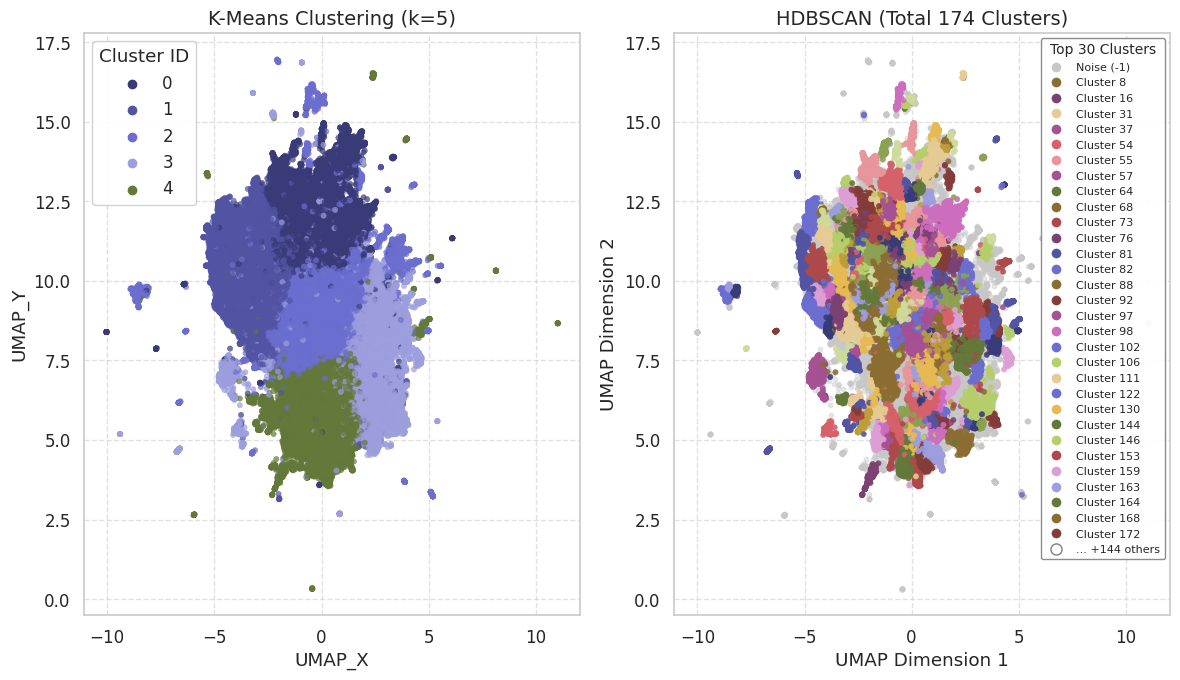

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  

sns.set_context("notebook", font_scale=1.1)
sns.set_style("whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

# -------------------------------------------------------
# Plot 1: K-Means
# -------------------------------------------------------
sns.scatterplot(
    x='UMAP_X', y='UMAP_Y',
    hue='KMeans_Cluster',
    data=train_df_clean,
    palette='tab20b',
    ax=ax1,
    alpha=0.7, s=15, edgecolor=None, legend='full'
)
ax1.set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='normal')
ax1.legend(title='Cluster ID', loc='upper left', frameon=True, framealpha=0.9)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_axisbelow(True)

# -------------------------------------------------------
# Plot 2: HDBSCAN
# -------------------------------------------------------
noise_data = train_df_clean[train_df_clean['HDBSCAN_Cluster'] == -1]
cluster_data = train_df_clean[train_df_clean['HDBSCAN_Cluster'] != -1]

unique_clusters = sorted(cluster_data['HDBSCAN_Cluster'].unique())
palette = sns.color_palette("tab20b", len(unique_clusters))
color_map = dict(zip(unique_clusters, palette))

ax2.scatter(
    noise_data['UMAP_X'], noise_data['UMAP_Y'],
    c="#c7c7c7", s=10, alpha=0.4, label='Noise'
)

sns.scatterplot(
    x='UMAP_X', y='UMAP_Y',
    hue='HDBSCAN_Cluster',
    data=cluster_data,
    palette=color_map,
    ax=ax2,
    legend=False,
    alpha=0.9, s=15, edgecolor=None
)

top_n = 30
top_clusters = cluster_data['HDBSCAN_Cluster'].value_counts().head(top_n).index.tolist()

all_handles = []
noise_circle = Line2D([0], [0], marker='o', color='w', label='Noise (-1)',
                      markerfacecolor='#c7c7c7', markersize=8)
all_handles.append(noise_circle)
for cluster_id in sorted(top_clusters):
    color = color_map[cluster_id]
    circle = Line2D([0], [0], marker='o', color='w', label=f'Cluster {cluster_id}',
                    markerfacecolor=color, markersize=8)
    all_handles.append(circle)

if len(unique_clusters) > top_n:
    others_circle = Line2D([0], [0], marker='o', color='w', label=f'... +{len(unique_clusters)-top_n} others',
                           markerfacecolor='white', markeredgecolor='gray', markersize=8)
    all_handles.append(others_circle)

ax2.legend(handles=all_handles, 
           title=f"Top {top_n} Clusters", 
           loc='upper right',   
           fontsize=8,          
           title_fontsize=10,
           frameon=True,        
           framealpha=0.9,      
           edgecolor='gray',
           ncol=1)              

ax2.set_title(f'HDBSCAN (Total {len(unique_clusters)} Clusters)', fontsize=14, fontweight='normal')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_axisbelow(True)
ax2.set_xlabel("UMAP Dimension 1")
ax2.set_ylabel("UMAP Dimension 2")

plt.tight_layout()
plt.show()

## 6. SEMANTIC TOPIC MODELING & INTERPRETATION

### 6.1 HDBSCAN Topic Profiling & Function Definition

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to Get Top Keywords per Cluster using TF-IDF (Used for both models)
def get_top_tfidf_words(df, cluster_col, n_top_words=10):
    results = {}
    # Use minimum 4 letters to filter out common small words
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]{4,}\b')

    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_df_filter = df[df[cluster_col] == cluster_id]
        cluster_text = cluster_df_filter['comment_text']

        # Skip very small clusters for stable TF-IDF
        if len(cluster_text) < 10:
            continue
        # Calculate Toxic Purity (%)
        toxic_count = cluster_df_filter['is_toxic'].sum()
        total_count = len(cluster_df_filter)
        purity = (toxic_count / total_count) * 100

        # TF-IDF Calculation and Keyword extraction
        tfidf_matrix = vectorizer.fit_transform(cluster_text)
        feature_names = vectorizer.get_feature_names_out()
        tfidf_sums = np.sum(tfidf_matrix.toarray(), axis=0)
        top_indices = tfidf_sums.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_indices]

        results[cluster_id] = {
            'keywords': ', '.join(top_words),
            'count': total_count,
            'purity': purity  # Keeping as NUMBER (Float) for correct sorting
        }
    return results
    
# HDBSCAN Execution
INTERPRET_LABELS_HDBSCAN = 'HDBSCAN_Cluster'
# Drop noise points (-1) for cleaner topic modeling
df_interpret_hdbscan = train_df_clean[train_df_clean[INTERPRET_LABELS_HDBSCAN] != -1].copy()
cluster_keywords_hdbscan = get_top_tfidf_words(df_interpret_hdbscan, INTERPRET_LABELS_HDBSCAN)

# Final Interpretation Table and Output (HDBSCAN)
interpretation_rows_hdbscan = []
for cluster_id, data in cluster_keywords_hdbscan.items():
    cluster_df = df_interpret_hdbscan[df_interpret_hdbscan[INTERPRET_LABELS_HDBSCAN] == cluster_id]
    representative_comment = cluster_df.sort_values(by='is_toxic', ascending=False)['comment_text'].head(1).iloc[0]

    interpretation_rows_hdbscan.append([
        cluster_id,
        data['count'],
        data['keywords'],
        data['purity'], # Keeping raw number
        representative_comment[:100] + '...'
    ])

interpretation_df_hdbscan = pd.DataFrame(interpretation_rows_hdbscan, columns=[
    'Cluster ID', 'Sample Count', 'Dominant Keywords (Topics)', 'Toxic Purity', 'Representative Comment Snippet'
])

# Sort numerically FIRST (FIXED)
full_sorted_df = interpretation_df_hdbscan.sort_values(by='Toxic Purity', ascending=False).copy()

# Save raw numeric data to CSV 
full_sorted_df.to_csv('HDBSCAN_Cluster_Interpretation_FULL.csv', index=False)

# Now add "%" sign for Display purpose only
full_sorted_df['Toxic Purity'] = full_sorted_df['Toxic Purity'].apply(lambda x: f"{x:.2f}%")

print("\nFinal Cluster Interpretation and Topic Profiling (HDBSCAN)")
print("\nTop 10 Clusters by Toxic Purity:")
print(full_sorted_df.head(10).to_markdown(index=False, numalign="right", stralign="left"))


Final Cluster Interpretation and Topic Profiling (HDBSCAN)

Top 10 Clusters by Toxic Purity:
|   Cluster ID |   Sample Count | Dominant Keywords (Topics)                                                              | Toxic Purity   | Representative Comment Snippet                                                                          |
|-------------:|---------------:|:----------------------------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------------------------------------------|
|          145 |            137 | faggot, fuck, fucking, like, know, bitch, just, time, shit, little                      | 97.81%         | I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex... |
|          146 |           1495 | fuck, suck, bitch, cunt, dick, asshole, fucking, cock, shit, like                       | 90.77%         | COCKSUCKER BEFORE YOU PI

### 6.2 HDBSCAN Word Cloud Visualization (Highest Toxicity Clusters)

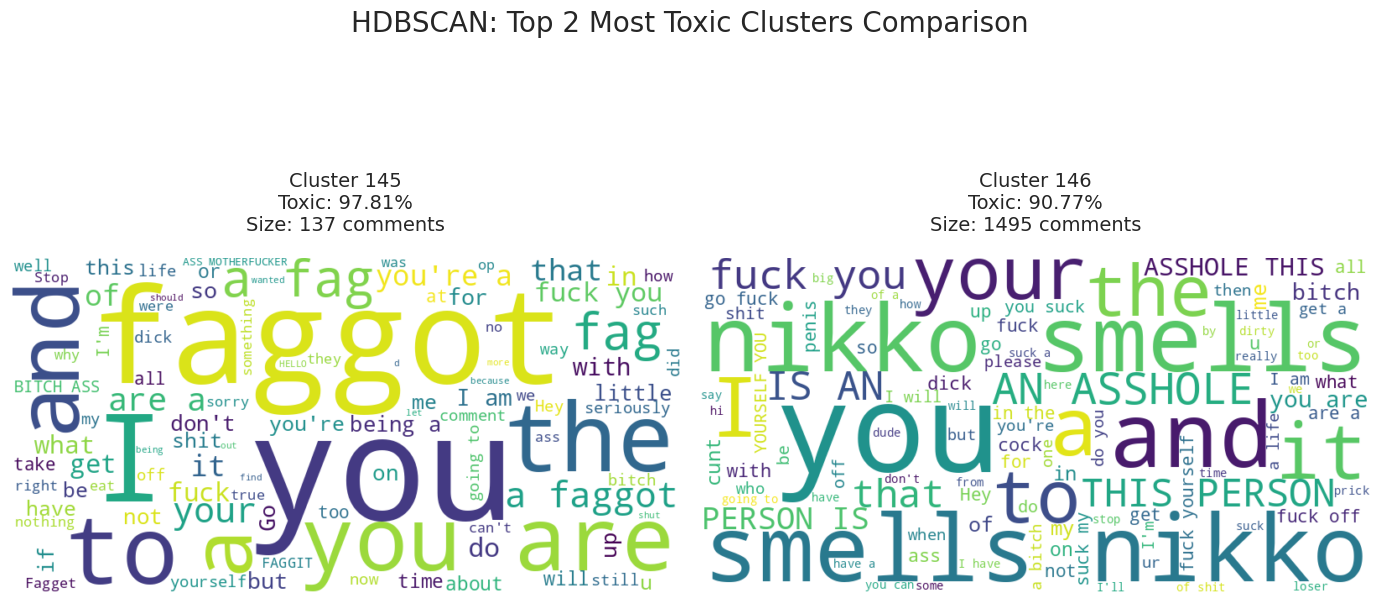

In [37]:
# Visualize the two highest toxicity clusters from HDBSCAN
HDBSCAN_CLUSTERS = full_sorted_df.head(2)['Cluster ID'].tolist()  # Top 2 most toxic clusters
CLUSTER_COL = 'HDBSCAN_Cluster'
HDBSCAN_DF = df_interpret_hdbscan # Using the filtered HDBSCAN dataframe

fig, axes = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle(f"HDBSCAN: Top 2 Most Toxic Clusters Comparison", fontsize=20)

for i, cluster_id in enumerate(HDBSCAN_CLUSTERS):
    cluster_text_series = HDBSCAN_DF[HDBSCAN_DF[CLUSTER_COL] == cluster_id]['comment_text']
    long_string = ' '.join(cluster_text_series.astype(str))

    wordcloud = WordCloud(
        background_color="white",
        max_words=100,
        width=800,
        height=400,
        colormap='viridis',
        stopwords=['just', 'like', 'think', 'know', 'people', 'article', 'wikipedia', 'page', 'fucking', 'talk', 'thanks']
    ).generate(long_string)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    
    # Get Purity and additional info
    cluster_data = full_sorted_df[full_sorted_df['Cluster ID'] == cluster_id].iloc[0]
    purity_value = cluster_data['Toxic Purity']
    cluster_size = cluster_data['Sample Count']
    
    axes[i].set_title(f"Cluster {cluster_id}\nToxic: {purity_value}\nSize: {cluster_size} comments", 
                     fontsize=14, pad=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('HDBSCAN_WordClouds_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.3 K-Means Topic Profiling

In [38]:
# K-MEANS Execution
INTERPRET_LABELS_KMEANS = 'KMeans_Cluster' 
# K-Means has NO noise (-1), so we use the whole dataframe
df_interpret_kmeans = train_df_clean.copy()

# Reuse the function defined in the previous cell
cluster_keywords_kmeans = get_top_tfidf_words(df_interpret_kmeans, INTERPRET_LABELS_KMEANS)

# Final Interpretation Table and Output (K-Means)
interpretation_rows_kmeans = []
for cluster_id, data in cluster_keywords_kmeans.items():
    cluster_df = df_interpret_kmeans[df_interpret_kmeans[INTERPRET_LABELS_KMEANS] == cluster_id]
    representative_comment = cluster_df.sort_values(by='is_toxic', ascending=False)['comment_text'].head(1).iloc[0]

    interpretation_rows_kmeans.append([
        cluster_id,
        data['count'],
        data['keywords'],
        data['purity'],
        representative_comment[:100] + '...'
    ])

kmeans_table = pd.DataFrame(interpretation_rows_kmeans, columns=[
    'Cluster ID', 'Sample Count', 'Dominant Keywords', 'Toxic Purity', 'Example'
])

# Sort numerically FIRST
kmeans_sorted_df = kmeans_table.sort_values(by='Toxic Purity', ascending=False).copy()

# Now add "%" sign for Display purpose only
kmeans_sorted_df['Toxic Purity'] = kmeans_sorted_df['Toxic Purity'].apply(lambda x: f"{x:.2f}%")

print("\nK-Means Cluster Topic Profiling")
print(kmeans_sorted_df.to_markdown(index=False, numalign="right", stralign="left"))


K-Means Cluster Topic Profiling
|   Cluster ID |   Sample Count | Dominant Keywords                                                               | Toxic Purity   | Example                                                                                                 |
|-------------:|---------------:|:--------------------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------------------------------------------|
|            3 |          28525 | talk, thanks, page, fuck, just, know, thank, like, good, think                  | 22.94%         | you are still a stupid cunt of a whore!                                                                 |
|              |                |                                                                                 |                |                                                                                                         |
|          

### 6.4 K-Means Word Cloud Visualization (Toxicity vs. Size)

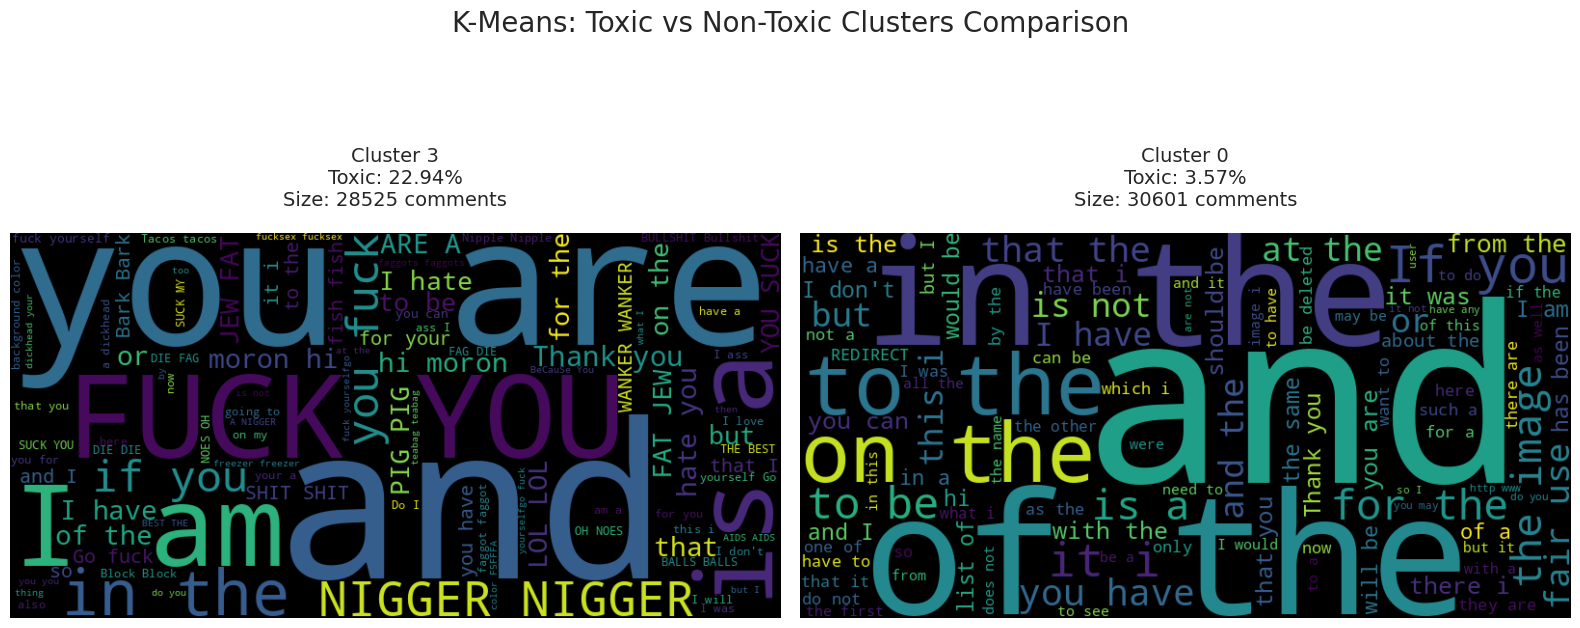

In [39]:
# Visualize Highest Toxicity and Lowest Toxicity Clusters
KMEANS_CLUSTERS = [kmeans_sorted_df.iloc[0]['Cluster ID'], kmeans_sorted_df.iloc[-1]['Cluster ID']]  # Most toxic and least toxic
CLUSTER_COL = 'KMeans_Cluster' 
KMEANS_DF = train_df_clean.copy() # Using the original dataframe

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle(f"K-Means: Toxic vs Non-Toxic Clusters Comparison", fontsize=20)

for i, cluster_id in enumerate(KMEANS_CLUSTERS):
    cluster_text_series = KMEANS_DF[KMEANS_DF[CLUSTER_COL] == cluster_id]['comment_text']
    long_string = ' '.join(cluster_text_series.astype(str))

    wordcloud = WordCloud(
        background_color="black",
        max_words=100,
        width=800,
        height=400,
        colormap='viridis', 
        stopwords=['just', 'like', 'think', 'know', 'people', 'article', 'wikipedia', 'page', 'talk', 'thanks']
    ).generate(long_string)

    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    
    # Get Purity from the kmeans_sorted_df
    purity_value = kmeans_sorted_df[kmeans_sorted_df['Cluster ID'] == cluster_id]['Toxic Purity'].iloc[0]
    
    # Add cluster size information
    cluster_size = len(cluster_text_series)
    
    axes[i].set_title(f"Cluster {cluster_id}\nToxic: {purity_value}\nSize: {cluster_size} comments", 
                     fontsize=14, pad=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('KMeans_WordClouds_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()